In [1]:
import glob
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier

In [2]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

In [3]:
def load_data(mypath):
    path = r'%s' %mypath
    allFiles = glob.glob(path + '*.txt')
    list_ = []
    for file_ in allFiles:
        with open(file_, "rb") as f:
            content = f.read()
        list_.append(content)
    data = pd.DataFrame(data={"words":list_})
    
    return data

In [4]:
def sample_data(trneg, trpos, teneg, tepos):
    
    neg = load_data(trneg).append(load_data(teneg),ignore_index=True)
    pos = load_data(trpos).append(load_data(tepos),ignore_index=True)
    sentiment = np.concatenate((np.ones(len(pos)), np.zeros(len(neg))))
    
    return pd.DataFrame(data={"sentiment":sentiment.reshape((-1,)), "words":np.concatenate((pos,neg)).reshape((-1,))})

In [5]:
train = sample_data(trneg='aclImdb/train/neg/', trpos='aclImdb/train/pos/'
                    , teneg='aclImdb/test/neg/', tepos='aclImdb/test/pos/')

In [6]:
train = train.astype(dtype= {"sentiment":int, "words":object})

In [7]:
train.head(2)

sentiment                                              words
0          1  b'For a movie that gets no respect there sure ...
1          1  b'Bizarre horror movie filled with famous face...

In [8]:
def clean(raws, remove_stopwords=True):
    raw = BeautifulSoup(raws).get_text()
    word = re.sub("[^a-zA-Z]", " ", raw).lower().split()
    if remove_stopwords:
        stop = set(stopwords.words("english"))
        useful = [u for u in word if not u in stop]
    
    return(useful)

In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
sentences = []

for word in train["words"]:
    sentences.append(clean(word, remove_stopwords=True))

In [11]:
sentences[0:1]

[['movie',
  'gets',
  'respect',
  'sure',
  'lot',
  'memorable',
  'quotes',
  'listed',
  'gem',
  'imagine',
  'movie',
  'joe',
  'piscopo',
  'actually',
  'funny',
  'maureen',
  'stapleton',
  'scene',
  'stealer',
  'moroni',
  'character',
  'absolute',
  'scream',
  'watch',
  'alan',
  'skipper',
  'hale',
  'jr',
  'police',
  'sgt']]

In [12]:
model = Word2Vec(sentences, workers=num_cores, vector_size=300, min_count=40, window=10, sample=1e-3)

In [13]:
len(model.wv)

12709

In [14]:
model.save("word2vec_300size")

In [15]:
def computeVec(words, model, num_features):
    Vec = np.zeros((num_features,), dtype="float32")
    n = 0
    index2words_set = set(model.wv.index_to_key)
    for word in words:
        if word in index2words_set:
            n = n + 1
            Vec = np.add(Vec, model.wv[word])
    Vec = np.divide(Vec, n)
    return Vec

In [16]:
def computeAvgVec(words, model, num_features):
    counter = 0
    Vec = np.zeros((len(words), num_features), dtype="float32")
    for word in words:
        Vec[counter] = computeVec(word, model, num_features)
        counter = counter + 1
    return Vec

In [17]:
trainVec = computeAvgVec(sentences, model, 300)

In [18]:
trainVec[0:2]

array([[ 5.81639111e-02, -2.44758740e-01, -6.59457669e-02,
        -4.20952767e-01, -1.88062176e-01,  4.86636251e-01,
        -2.54285514e-01,  1.54138342e-01, -2.92309225e-01,
        -3.03730935e-01, -2.24884655e-02, -7.14734616e-03,
         1.28957540e-01,  1.88010558e-01,  1.56822726e-01,
        -1.80450261e-01, -2.52609015e-01, -3.89610901e-02,
         5.47732078e-02, -5.30938745e-01,  4.22439456e-01,
        -5.14348876e-03, -1.58816695e-01,  3.42687070e-01,
        -3.14314812e-01,  1.07962362e-01, -1.81698278e-01,
         1.82138845e-01,  1.09986737e-01,  3.72194834e-02,
        -4.07328643e-02, -9.14036669e-03, -8.91695023e-02,
        -8.95131305e-02, -6.16189577e-02, -3.99744697e-03,
        -2.53876299e-01,  1.32623777e-01, -2.04954669e-01,
        -1.45476148e-01,  6.75368086e-02,  1.61230773e-01,
        -4.33940232e-01,  5.96020855e-02, -2.19104961e-02,
         1.65080845e-01,  6.23621702e-01, -1.82795282e-02,
         2.61951566e-01,  1.62366807e-01,  2.35364120e-0

In [19]:
trainVecs = []
trains = []

for i in range(0,len(trainVec)):
    if np.isnan(trainVec[i]).any()==False:
        trainVecs.append(trainVec[i])
        trains.append(train.iloc[i])

trainVecs = np.array(trainVecs)
trains = pd.DataFrame(trains)

In [20]:
trains.groupby(['sentiment']).agg(counts = ('words', 'count'))

counts
sentiment        
0           25000
1           25000

In [21]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xg

from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from scipy import interp

from sklearn.model_selection import RandomizedSearchCV, train_test_split

import matplotlib.pylab as plt
import matplotlib.patches as patches

%matplotlib inline

In [22]:
seed = 40

In [23]:
trains.head(2)

sentiment                                              words
0          1  b'For a movie that gets no respect there sure ...
1          1  b'Bizarre horror movie filled with famous face...

CV Mean: 0.8154600000000001   Std: 0.007493490508434639   Mean ROC (AUC = 0.89)


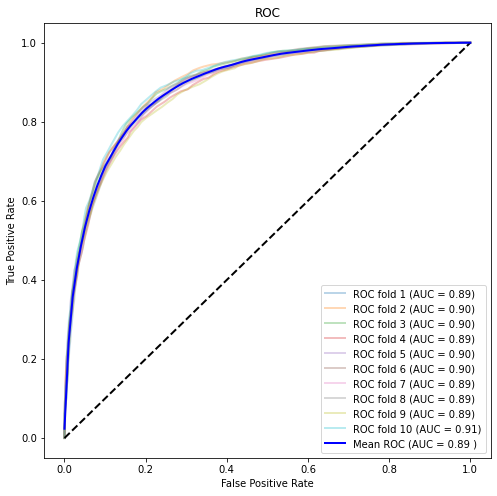

/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:10:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:14:02] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:17:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:20:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:23:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:26:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:29:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:33:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/karheng.ng/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:38:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV Mean: 0.8384   Std: 0.006534217627229748   Mean ROC (AUC = 0.89)


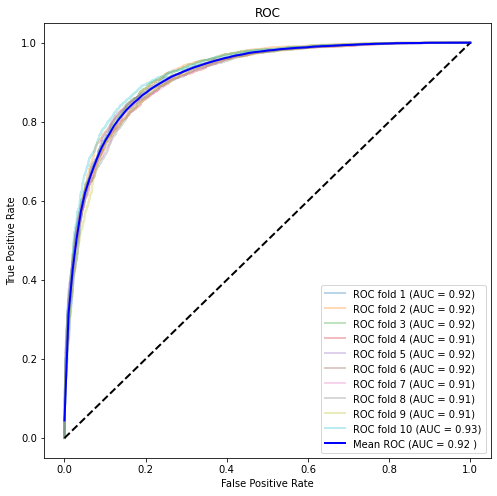

In [139]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

classifiers=['Random Forest','XGBoost']
models=[RandomForestClassifier(random_state=seed), xg.XGBClassifier(random_state=seed)]

for m in models:

    fig = plt.figure(figsize=[8,8])

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1

    accuracy = []
    
    clf = m

    for cvtrain,cvtest in kfold.split(trainVecs, trains["sentiment"]):

        clf.fit(trainVecs[cvtrain], trains.iloc[cvtrain, 0])
        cv_result_proba = clf.predict_proba(trainVecs[cvtest])
        cv_result = clf.predict(trainVecs[cvtest])

        accuracy.append(metrics.accuracy_score(trains.iloc[cvtest, 0], cv_result))

        fpr, tpr, t = metrics.roc_curve(trains.iloc[cvtest, 0], cv_result_proba[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1

    print('CV Mean:', np.mean(accuracy),'  Std:', np.std(accuracy), '  Mean ROC (AUC = %0.2f)' % (mean_auc))

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

# Parameters Tuning

In [24]:
x_train, x_test, y_train, y_test = train_test_split(trainVecs, trains["sentiment"], test_size=0.30, random_state=seed, stratify=trains["sentiment"])

In [25]:
n_estimators = range(100,1000,200)
learn_rate = [0.05,0.1,0.15,0.2,0.3]
max_depth = [2,4,6,7,8]

param_dic = {
    'learning_rate':learn_rate,
    'n_estimators':n_estimators,
    'max_depth':max_depth
}

gb_xg = xg.XGBClassifier(random_state=seed, use_label_encoder=False, n_jobs=-1)

random_search = RandomizedSearchCV(gb_xg, param_distributions=param_dic, n_iter=10, scoring="roc_auc", n_jobs=-1, verbose=1).fit(x_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
gb_xg = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 287.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 305.0min finished


[03:24:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Model parameters: {'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.15}
Best Model mean accuracy: 0.930963469387755


In [27]:
import pickle
file_name = "xgb_clf.pkl"

pickle.dump(gb_xg, open(file_name, "wb"))

In [29]:
gb_xg.fit(x_train, y_train)

predicted_prob = gb_xg.predict_proba(x_test)[:,1]
predicted = gb_xg.predict(x_test)

[07:32:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))

recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.85
Auc: 0.93
Recall (all 1s predicted right): 0.86
Precision (confidence when predicting a 1): 0.85
Detail:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      7500
           1       0.85      0.86      0.86      7500

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



In [2]:
from sentiment_classifier import SentiClassifier

In [3]:
classifier = SentiClassifier()
output = classifier.sentiment_analyze("Glad you are fully recovered")
print(output)

positive


In [5]:
classifier.sentiment_analyze('''
We are organising Secret Santa this Xmas!! :christmas_tree:If you can do spare 2 minutes today to fill in the gform for us so we can do the necessary planning! If you prefer not to join Secret Santa that's absolutely okay too, though please share your mailing address so I can post you an Xmas card
''')

'positive'